In [3]:
# Data Manipulation and Handling
import polars as pl
import pandas as pd
import numpy as np
import psycopg2

# DB Credentials
from dotenv import load_dotenv
import os
import sys
from sqlalchemy import create_engine

# Machine Learning Libraries
import torch
import xgboost as xgb
import lightgbm as lgb
# from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Gradient Boosting Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model Lifecycle Management
import mlflow
import mlflow.sklearn

# Distributed Computing
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier as SparkRFClassifier

# Model Interpretability
import shap

# Hyperparameter Optimization
import optuna

# Automated Feature Engineering
import featuretools as ft

# Add parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Custom Modules
from fetch_data_hook import fetch_sql_code, fetch_sql_file

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.


# ML Pipeline Flow

In [4]:
# 1. EDA Analysis
# 2. Feature Engineering
# 3. Train-Test Split
# 4. Feature Scaling: {normalization/standardization, dimension reduction techniques, handling imbalance datasets/sampling}
# 5. Model Training -> Tuning -> Evaluating
# 6. Model Prediction
# 7. Model Deployment

In [5]:
churn_df = fetch_sql_code('''
WITH temp1 AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp) AS rn,
        timestamp::date - ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp)::int AS streak_id
    FROM
        equity_value_data
),
temp2 AS (
    SELECT
        user_id,
        MIN(timestamp::date) AS start_streak_date,
        MAX(timestamp::date) AS end_streak_date,
        COUNT(*) AS duration_of_above10_streak
    FROM
        temp1
    GROUP BY
        user_id, streak_id
),
temp3 AS (
    SELECT
        *,
        LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS prev_above10_streak_date,
        start_streak_date - LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS duration_between_above10_streaks
    FROM
        temp2
)
SELECT distinct user_id
FROM temp3
WHERE duration_between_above10_streaks >= 28
''')
churn_df
churn_users = set(churn_df['user_id'].tolist())

df = fetch_sql_code('''
select * from features_data
''')

df['churn_flag'] = df['user_id'].apply(lambda x: 1 if x in churn_users else 0 )
df


,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn_flag
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0
...,...,...,...,...,...,...,...,...,...,...
5579,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.339283,stock,300.0,long_time_horizon,03880c726d8a4e5db006afe4119ad974,0
5580,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,7.241383,stock,100.0,short_time_horizon,ae8315109657f44852b24c6bca4decd6,1
5581,med_risk_tolerance,no_investment_exp,very_important_liq_need,both,22.967167,stock,50.0,short_time_horizon,f29c174989f9737058fe808fcf264135,0
5582,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,10.338417,stock,100.0,long_time_horizon,24843497d1de88b2e7233f694436cb3a,0


In [6]:
'''
This pipeline includes the following:

Data Preprocessing: Label encoding, scaling, and feature engineering.
Handling Imbalance: Using SMOTE for oversampling the minority class.
Modeling and Hyperparameter Tuning: Using Optuna to tune the hyperparameters of models like XGBoost, LightGBM, RandomForest, and Logistic Regression.
Evaluation: Automatically selecting the best model with the highest AUC score.
Explainability: Using SHAP to interpret the model.'''

'\nThis pipeline includes the following:\n\nData Preprocessing: Label encoding, scaling, and feature engineering.\nHandling Imbalance: Using SMOTE for oversampling the minority class.\nModeling and Hyperparameter Tuning: Using Optuna to tune the hyperparameters of models like XGBoost, LightGBM, RandomForest, and Logistic Regression.\nEvaluation: Automatically selecting the best model with the highest AUC score.\nExplainability: Using SHAP to interpret the model.'

### Step 1: Data Preprocessing and Feature Engineering

In [7]:
# Label encoding for categorical variables
label_enc = LabelEncoder()
df['risk_tolerance'] = label_enc.fit_transform(df['risk_tolerance'])
df['investment_experience'] = label_enc.fit_transform(df['investment_experience'])
df['liquidity_needs'] = label_enc.fit_transform(df['liquidity_needs'])
df['platform'] = label_enc.fit_transform(df['platform'])
df['time_horizon'] = label_enc.fit_transform(df['time_horizon'])

# Scaling the numerical features
scaler = StandardScaler()
df[['time_spent', 'first_deposit_amount']] = scaler.fit_transform(df[['time_spent', 'first_deposit_amount']])

# Feature Engineering: Additional features
df['deposit_per_time'] = df['first_deposit_amount'] / (df['time_spent'] + 1)  # Avoid division by zero
df['is_high_risk'] = (df['risk_tolerance'] == 0).astype(int)  # Assuming 0 = high risk


# Split the dataset into features and target
X = df.drop(columns=['user_id', 'churn_flag'])

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

y = df['churn_flag']

# Handle imbalance using SMOTE
smote = SMOTE(random_state=42)
X_original = X  # Store the original feature matrix
y_original = y  # Store the original target variable
X_resampled, y_resampled = smote.fit_resample(X_original, y_original)


Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "c:\Users\cheng\Workspace\robinhood_classifer\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\cheng\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 489, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\cheng\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 854, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\cheng\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 1307, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


### Step 2: Model Definition and Objective Function for Optuna

In [8]:
# Define the models: XGBoost, LightGBM, RandomForest, and Logistic Regression
# Optuna will optimize each model's hyperparameters.
# Now proceed with Optuna's hyperparameter tuning on resampled data


def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['xgboost', 'lightgbm', 'randomforest', 'logistic'])

    if model_type == 'xgboost':
        model = xgb.XGBClassifier(
            max_depth=trial.suggest_int('max_depth', 3, 10),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            subsample=trial.suggest_float('subsample', 0.6, 1.0)
        )

    elif model_type == 'lightgbm':
        model = lgb.LGBMClassifier(
            num_leaves=trial.suggest_int('num_leaves', 20, 150),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            feature_fraction=trial.suggest_float('feature_fraction', 0.6, 1.0)
        )

    elif model_type == 'randomforest':
        model = RandomForestClassifier(
            max_depth=trial.suggest_int('max_depth', 3, 10),
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        )

    elif model_type == 'logistic':
        model = LogisticRegression(
            penalty=trial.suggest_categorical('penalty', ['l1', 'l2']),
            C=trial.suggest_float('C', 0.01, 10, log=True),
            solver='liblinear'
        )

    # Train-Test split (using resampled data for training)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate AUC score
    auc = roc_auc_score(y_test, y_pred)

    return auc


### Step 3: Running Optuna for Hyperparameter Tuning

In [9]:
# Run Optuna for hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best trial and parameters
print(f"Best Trial: {study.best_trial}")
print(f"Best Parameters: {study.best_params}")

[I 2024-10-03 20:03:44,079] A new study created in memory with name: no-name-981ed2f1-dc17-4907-b648-93cbdb053610
[I 2024-10-03 20:03:44,265] Trial 0 finished with value: 0.805030881434093 and parameters: {'model_type': 'xgboost', 'max_depth': 6, 'learning_rate': 0.011448156555939885, 'n_estimators': 135, 'subsample': 0.7252500978164157}. Best is trial 0 with value: 0.805030881434093.
[I 2024-10-03 20:03:44,288] Trial 1 finished with value: 0.5821796075897473 and parameters: {'model_type': 'logistic', 'penalty': 'l1', 'C': 0.010380687297888038}. Best is trial 0 with value: 0.805030881434093.
[I 2024-10-03 20:03:44,461] Trial 2 finished with value: 0.8514770480524436 and parameters: {'model_type': 'xgboost', 'max_depth': 3, 'learning_rate': 0.08589295681912867, 'n_estimators': 203, 'subsample': 0.9356712583521857}. Best is trial 2 with value: 0.8514770480524436.
[I 2024-10-03 20:03:44,784] Trial 3 finished with value: 0.6396975128182241 and parameters: {'model_type': 'logistic', 'penalt

[LightGBM] [Warning] feature_fraction is set=0.7124416368965777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7124416368965777
[LightGBM] [Warning] feature_fraction is set=0.7124416368965777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7124416368965777
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427
[LightGBM] [Warning] feature_fraction is set=0.7124416368965777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.712

[I 2024-10-03 20:03:45,887] Trial 6 finished with value: 0.6746653359358152 and parameters: {'model_type': 'randomforest', 'max_depth': 3, 'n_estimators': 168, 'max_features': 'log2'}. Best is trial 4 with value: 0.89423177940095.
[I 2024-10-03 20:03:45,908] Trial 7 finished with value: 0.6231888408186285 and parameters: {'model_type': 'logistic', 'penalty': 'l2', 'C': 0.011348143943967779}. Best is trial 4 with value: 0.89423177940095.


[LightGBM] [Warning] feature_fraction is set=0.8210651115378719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8210651115378719
[LightGBM] [Warning] feature_fraction is set=0.8210651115378719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8210651115378719
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 20:03:46,287] Trial 8 finished with value: 0.9225896564771231 and parameters: {'model_type': 'lightgbm', 'num_leaves': 52, 'learning_rate': 0.06716408979661295, 'n_estimators': 260, 'feature_fraction': 0.8210651115378719}. Best is trial 8 with value: 0.9225896564771231.
[I 2024-10-03 20:03:46,403] Trial 9 finished with value: 0.91435803031823 and parameters: {'model_type': 'lightgbm', 'num_leaves': 32, 'learning_rate': 0.19367856563607894, 'n_estimators': 119, 'feature_fraction': 0.8833685559301647}. Best is trial 8 with value: 0.9225896564771231.


[LightGBM] [Warning] feature_fraction is set=0.8210651115378719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8210651115378719
[LightGBM] [Warning] feature_fraction is set=0.8833685559301647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8833685559301647
[LightGBM] [Warning] feature_fraction is set=0.8833685559301647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8833685559301647
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:03:47,434] Trial 10 finished with value: 0.9229701944199353 and parameters: {'model_type': 'lightgbm', 'num_leaves': 139, 'learning_rate': 0.031728193404284774, 'n_estimators': 298, 'feature_fraction': 0.943383654076282}. Best is trial 10 with value: 0.9229701944199353.


[LightGBM] [Warning] feature_fraction is set=0.943383654076282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.943383654076282
[LightGBM] [Warning] feature_fraction is set=0.9924025821702229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9924025821702229
[LightGBM] [Warning] feature_fraction is set=0.9924025821702229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9924025821702229
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from sco

[I 2024-10-03 20:03:48,479] Trial 11 finished with value: 0.9235746711417561 and parameters: {'model_type': 'lightgbm', 'num_leaves': 148, 'learning_rate': 0.029006659697636765, 'n_estimators': 300, 'feature_fraction': 0.9924025821702229}. Best is trial 11 with value: 0.9235746711417561.


[LightGBM] [Warning] feature_fraction is set=0.9924025821702229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9924025821702229
[LightGBM] [Warning] feature_fraction is set=0.9988330208068654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9988330208068654
[LightGBM] [Warning] feature_fraction is set=0.9988330208068654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9988330208068654
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:03:49,503] Trial 12 finished with value: 0.921725102707724 and parameters: {'model_type': 'lightgbm', 'num_leaves': 150, 'learning_rate': 0.024476402442878742, 'n_estimators': 298, 'feature_fraction': 0.9988330208068654}. Best is trial 11 with value: 0.9235746711417561.


[LightGBM] [Warning] feature_fraction is set=0.9988330208068654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9988330208068654
[LightGBM] [Warning] feature_fraction is set=0.9765034906869846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9765034906869846
[LightGBM] [Warning] feature_fraction is set=0.9765034906869846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9765034906869846
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:03:50,608] Trial 13 finished with value: 0.9232784558256075 and parameters: {'model_type': 'lightgbm', 'num_leaves': 148, 'learning_rate': 0.0315184486716697, 'n_estimators': 296, 'feature_fraction': 0.9765034906869846}. Best is trial 11 with value: 0.9235746711417561.


[LightGBM] [Warning] feature_fraction is set=0.9765034906869846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9765034906869846


[I 2024-10-03 20:03:52,812] Trial 14 finished with value: 0.8261640669494009 and parameters: {'model_type': 'randomforest', 'max_depth': 10, 'n_estimators': 238, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.9235746711417561.


[LightGBM] [Warning] feature_fraction is set=0.9907580416023605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9907580416023605
[LightGBM] [Warning] feature_fraction is set=0.9907580416023605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9907580416023605
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 20:03:53,467] Trial 15 finished with value: 0.9213686569439585 and parameters: {'model_type': 'lightgbm', 'num_leaves': 108, 'learning_rate': 0.029183481296112337, 'n_estimators': 247, 'feature_fraction': 0.9907580416023605}. Best is trial 11 with value: 0.9235746711417561.


[LightGBM] [Warning] feature_fraction is set=0.9907580416023605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9907580416023605
[LightGBM] [Warning] feature_fraction is set=0.6239627182341867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6239627182341867
[LightGBM] [Warning] feature_fraction is set=0.6239627182341867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6239627182341867
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:03:54,221] Trial 16 finished with value: 0.9139774923754178 and parameters: {'model_type': 'lightgbm', 'num_leaves': 115, 'learning_rate': 0.021387530728744705, 'n_estimators': 271, 'feature_fraction': 0.6239627182341867}. Best is trial 11 with value: 0.9235746711417561.


[LightGBM] [Warning] feature_fraction is set=0.6239627182341867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6239627182341867
[LightGBM] [Warning] feature_fraction is set=0.8932404381030314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8932404381030314
[LightGBM] [Warning] feature_fraction is set=0.8932404381030314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8932404381030314
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:03:54,403] Trial 17 finished with value: 0.9010376225047809 and parameters: {'model_type': 'lightgbm', 'num_leaves': 123, 'learning_rate': 0.04383154273168933, 'n_estimators': 58, 'feature_fraction': 0.8932404381030314}. Best is trial 11 with value: 0.9235746711417561.


[LightGBM] [Warning] feature_fraction is set=0.8932404381030314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8932404381030314


[I 2024-10-03 20:04:02,094] Trial 18 finished with value: 0.8757169398035184 and parameters: {'model_type': 'randomforest', 'max_depth': 10, 'n_estimators': 240, 'max_features': None}. Best is trial 11 with value: 0.9235746711417561.


[LightGBM] [Warning] feature_fraction is set=0.8897652358996161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8897652358996161
[LightGBM] [Warning] feature_fraction is set=0.8897652358996161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8897652358996161
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 20:04:02,597] Trial 19 finished with value: 0.9050932051366105 and parameters: {'model_type': 'lightgbm', 'num_leaves': 88, 'learning_rate': 0.017046310746776445, 'n_estimators': 215, 'feature_fraction': 0.8897652358996161}. Best is trial 11 with value: 0.9235746711417561.


[LightGBM] [Warning] feature_fraction is set=0.8897652358996161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8897652358996161
[LightGBM] [Warning] feature_fraction is set=0.7681772228763208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7681772228763208
[LightGBM] [Warning] feature_fraction is set=0.7681772228763208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7681772228763208
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:03,415] Trial 20 finished with value: 0.922958148330412 and parameters: {'model_type': 'lightgbm', 'num_leaves': 135, 'learning_rate': 0.0455427094742868, 'n_estimators': 278, 'feature_fraction': 0.7681772228763208}. Best is trial 11 with value: 0.9235746711417561.


[LightGBM] [Warning] feature_fraction is set=0.7681772228763208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7681772228763208
[LightGBM] [Warning] feature_fraction is set=0.9492410560480411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9492410560480411
[LightGBM] [Warning] feature_fraction is set=0.9492410560480411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9492410560480411
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:04,332] Trial 21 finished with value: 0.9248799933015843 and parameters: {'model_type': 'lightgbm', 'num_leaves': 149, 'learning_rate': 0.031628970531864614, 'n_estimators': 296, 'feature_fraction': 0.9492410560480411}. Best is trial 21 with value: 0.9248799933015843.


[LightGBM] [Warning] feature_fraction is set=0.9492410560480411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9492410560480411
[LightGBM] [Warning] feature_fraction is set=0.9468774905749642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9468774905749642
[LightGBM] [Warning] feature_fraction is set=0.9468774905749642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9468774905749642
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:05,731] Trial 22 finished with value: 0.922958148330412 and parameters: {'model_type': 'lightgbm', 'num_leaves': 149, 'learning_rate': 0.04119185589535271, 'n_estimators': 299, 'feature_fraction': 0.9468774905749642}. Best is trial 21 with value: 0.9248799933015843.


[LightGBM] [Warning] feature_fraction is set=0.9468774905749642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9468774905749642
[LightGBM] [Warning] feature_fraction is set=0.9367321308026367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9367321308026367
[LightGBM] [Warning] feature_fraction is set=0.9367321308026367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9367321308026367
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:06,733] Trial 23 finished with value: 0.9181414898129578 and parameters: {'model_type': 'lightgbm', 'num_leaves': 127, 'learning_rate': 0.016937605655838208, 'n_estimators': 271, 'feature_fraction': 0.9367321308026367}. Best is trial 21 with value: 0.9248799933015843.


[LightGBM] [Warning] feature_fraction is set=0.9367321308026367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9367321308026367
[LightGBM] [Warning] feature_fraction is set=0.9919736837002733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9919736837002733
[LightGBM] [Warning] feature_fraction is set=0.9919736837002733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9919736837002733
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:07,296] Trial 24 finished with value: 0.921725102707724 and parameters: {'model_type': 'lightgbm', 'num_leaves': 99, 'learning_rate': 0.13405073304207085, 'n_estimators': 225, 'feature_fraction': 0.9919736837002733}. Best is trial 21 with value: 0.9248799933015843.


[LightGBM] [Warning] feature_fraction is set=0.9919736837002733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9919736837002733
[LightGBM] [Warning] feature_fraction is set=0.9410622903035069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9410622903035069
[LightGBM] [Warning] feature_fraction is set=0.9410622903035069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9410622903035069
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:08,392] Trial 25 finished with value: 0.922341625519068 and parameters: {'model_type': 'lightgbm', 'num_leaves': 150, 'learning_rate': 0.033629002969198706, 'n_estimators': 279, 'feature_fraction': 0.9410622903035069}. Best is trial 21 with value: 0.9248799933015843.
[I 2024-10-03 20:04:08,433] Trial 26 finished with value: 0.638428328926966 and parameters: {'model_type': 'logistic', 'penalty': 'l2', 'C': 6.752796152742894}. Best is trial 21 with value: 0.9248799933015843.


[LightGBM] [Warning] feature_fraction is set=0.9410622903035069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9410622903035069


[I 2024-10-03 20:04:09,965] Trial 27 finished with value: 0.7345091238266911 and parameters: {'model_type': 'randomforest', 'max_depth': 6, 'n_estimators': 254, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.9248799933015843.
[I 2024-10-03 20:04:10,377] Trial 28 finished with value: 0.897470992621474 and parameters: {'model_type': 'xgboost', 'max_depth': 8, 'learning_rate': 0.05879871863481422, 'n_estimators': 287, 'subsample': 0.6023148412976906}. Best is trial 21 with value: 0.9248799933015843.
[I 2024-10-03 20:04:10,593] Trial 29 finished with value: 0.8399558520692813 and parameters: {'model_type': 'xgboost', 'max_depth': 5, 'learning_rate': 0.018035235162742254, 'n_estimators': 260, 'subsample': 0.999832246491021}. Best is trial 21 with value: 0.9248799933015843.


[LightGBM] [Warning] feature_fraction is set=0.82568863426389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.82568863426389
[LightGBM] [Warning] feature_fraction is set=0.82568863426389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.82568863426389
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 20:04:11,043] Trial 30 finished with value: 0.9133971078326438 and parameters: {'model_type': 'lightgbm', 'num_leaves': 130, 'learning_rate': 0.025827329040218346, 'n_estimators': 152, 'feature_fraction': 0.82568863426389}. Best is trial 21 with value: 0.9248799933015843.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.82568863426389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.82568863426389
[LightGBM] [Warning] feature_fraction is set=0.945988815815377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.945988815815377
[LightGBM] [Warning] feature_fraction is set=0.945988815815377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.945988815815377
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.5

[I 2024-10-03 20:04:12,029] Trial 31 finished with value: 0.9264213003299443 and parameters: {'model_type': 'lightgbm', 'num_leaves': 137, 'learning_rate': 0.03621743167922309, 'n_estimators': 299, 'feature_fraction': 0.945988815815377}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.945988815815377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.945988815815377
[LightGBM] [Warning] feature_fraction is set=0.9542813368224631, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9542813368224631
[LightGBM] [Warning] feature_fraction is set=0.9542813368224631, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9542813368224631
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from sco

[I 2024-10-03 20:04:12,906] Trial 32 finished with value: 0.9226619330142634 and parameters: {'model_type': 'lightgbm', 'num_leaves': 138, 'learning_rate': 0.03474832161198397, 'n_estimators': 300, 'feature_fraction': 0.9542813368224631}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9542813368224631, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9542813368224631
[LightGBM] [Warning] feature_fraction is set=0.9038175503248401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9038175503248401
[LightGBM] [Warning] feature_fraction is set=0.9038175503248401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9038175503248401
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:14,062] Trial 33 finished with value: 0.9232784558256075 and parameters: {'model_type': 'lightgbm', 'num_leaves': 150, 'learning_rate': 0.04623769026971741, 'n_estimators': 280, 'feature_fraction': 0.9038175503248401}. Best is trial 31 with value: 0.9264213003299443.
[I 2024-10-03 20:04:14,094] Trial 34 finished with value: 0.6405960326105417 and parameters: {'model_type': 'logistic', 'penalty': 'l2', 'C': 0.172648680611141}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9038175503248401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9038175503248401
[LightGBM] [Warning] feature_fraction is set=0.9722462157435682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9722462157435682
[LightGBM] [Warning] feature_fraction is set=0.9722462157435682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9722462157435682
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:14,885] Trial 35 finished with value: 0.919507042420403 and parameters: {'model_type': 'lightgbm', 'num_leaves': 138, 'learning_rate': 0.02166191491980817, 'n_estimators': 263, 'feature_fraction': 0.9722462157435682}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9722462157435682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9722462157435682


[I 2024-10-03 20:04:15,285] Trial 36 finished with value: 0.8782936181002566 and parameters: {'model_type': 'xgboost', 'max_depth': 8, 'learning_rate': 0.014659687324900994, 'n_estimators': 285, 'subsample': 0.8629705358066314}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9150912869916704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9150912869916704
[LightGBM] [Warning] feature_fraction is set=0.9150912869916704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9150912869916704
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 20:04:15,906] Trial 37 finished with value: 0.9223175333400213 and parameters: {'model_type': 'lightgbm', 'num_leaves': 116, 'learning_rate': 0.03475524284903403, 'n_estimators': 227, 'feature_fraction': 0.9150912869916704}. Best is trial 31 with value: 0.9264213003299443.
[I 2024-10-03 20:04:15,967] Trial 38 finished with value: 0.6398710949934872 and parameters: {'model_type': 'logistic', 'penalty': 'l1', 'C': 0.13387033237684173}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9150912869916704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9150912869916704
[LightGBM] [Warning] feature_fraction is set=0.8595701659597379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8595701659597379
[LightGBM] [Warning] feature_fraction is set=0.8595701659597379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8595701659597379
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:16,650] Trial 39 finished with value: 0.9217130566182006 and parameters: {'model_type': 'lightgbm', 'num_leaves': 138, 'learning_rate': 0.05614642438754775, 'n_estimators': 204, 'feature_fraction': 0.8595701659597379}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.8595701659597379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8595701659597379


[I 2024-10-03 20:04:17,947] Trial 40 finished with value: 0.6927322979752301 and parameters: {'model_type': 'randomforest', 'max_depth': 4, 'n_estimators': 283, 'max_features': 'log2'}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9184748813923926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9184748813923926
[LightGBM] [Warning] feature_fraction is set=0.9184748813923926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9184748813923926
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 20:04:18,974] Trial 41 finished with value: 0.9232905019151307 and parameters: {'model_type': 'lightgbm', 'num_leaves': 148, 'learning_rate': 0.04524498958986896, 'n_estimators': 285, 'feature_fraction': 0.9184748813923926}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9184748813923926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9184748813923926
[LightGBM] [Warning] feature_fraction is set=0.9733722571229054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9733722571229054
[LightGBM] [Warning] feature_fraction is set=0.9733722571229054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9733722571229054
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:19,937] Trial 42 finished with value: 0.9220454102029193 and parameters: {'model_type': 'lightgbm', 'num_leaves': 143, 'learning_rate': 0.03929932520721003, 'n_estimators': 289, 'feature_fraction': 0.9733722571229054}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9733722571229054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9733722571229054
[LightGBM] [Warning] feature_fraction is set=0.9273901708415027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9273901708415027
[LightGBM] [Warning] feature_fraction is set=0.9273901708415027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9273901708415027
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:20,754] Trial 43 finished with value: 0.925115978170116 and parameters: {'model_type': 'lightgbm', 'num_leaves': 127, 'learning_rate': 0.026790922961261347, 'n_estimators': 266, 'feature_fraction': 0.9273901708415027}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9273901708415027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9273901708415027
[LightGBM] [Warning] feature_fraction is set=0.9222258055372751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9222258055372751
[LightGBM] [Warning] feature_fraction is set=0.9222258055372751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9222258055372751
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 20:04:21,510] Trial 44 finished with value: 0.9201597035003173 and parameters: {'model_type': 'lightgbm', 'num_leaves': 125, 'learning_rate': 0.02575517933678779, 'n_estimators': 266, 'feature_fraction': 0.9222258055372751}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9222258055372751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9222258055372751
[LightGBM] [Warning] feature_fraction is set=0.9587814329919311, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9587814329919311
[LightGBM] [Warning] feature_fraction is set=0.9587814329919311, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9587814329919311
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:22,082] Trial 45 finished with value: 0.9229822405094587 and parameters: {'model_type': 'lightgbm', 'num_leaves': 132, 'learning_rate': 0.09162071082129271, 'n_estimators': 186, 'feature_fraction': 0.9587814329919311}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9587814329919311, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9587814329919311


[I 2024-10-03 20:04:22,484] Trial 46 finished with value: 0.879907201665757 and parameters: {'model_type': 'xgboost', 'max_depth': 9, 'learning_rate': 0.012842726679119445, 'n_estimators': 253, 'subsample': 0.6022221501596032}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.867384138524601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.867384138524601
[LightGBM] [Warning] feature_fraction is set=0.867384138524601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.867384138524601
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 20:04:23,225] Trial 47 finished with value: 0.9213807030334819 and parameters: {'model_type': 'lightgbm', 'num_leaves': 119, 'learning_rate': 0.07113100092006652, 'n_estimators': 269, 'feature_fraction': 0.867384138524601}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.867384138524601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.867384138524601
[LightGBM] [Warning] feature_fraction is set=0.9196685615140942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9196685615140942
[LightGBM] [Warning] feature_fraction is set=0.9196685615140942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9196685615140942
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from sco

[I 2024-10-03 20:04:23,499] Trial 48 finished with value: 0.9168843520112231 and parameters: {'model_type': 'lightgbm', 'num_leaves': 105, 'learning_rate': 0.04977561848652425, 'n_estimators': 102, 'feature_fraction': 0.9196685615140942}. Best is trial 31 with value: 0.9264213003299443.
[I 2024-10-03 20:04:23,544] Trial 49 finished with value: 0.6374674064413798 and parameters: {'model_type': 'logistic', 'penalty': 'l2', 'C': 7.692972758895048}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9196685615140942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9196685615140942
[LightGBM] [Warning] feature_fraction is set=0.768789268867706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.768789268867706
[LightGBM] [Warning] feature_fraction is set=0.768789268867706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.768789268867706
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score

[I 2024-10-03 20:04:24,042] Trial 50 finished with value: 0.9216769183496305 and parameters: {'model_type': 'lightgbm', 'num_leaves': 73, 'learning_rate': 0.09735392148562005, 'n_estimators': 288, 'feature_fraction': 0.768789268867706}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.768789268867706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.768789268867706
[LightGBM] [Warning] feature_fraction is set=0.9780489201623761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9780489201623761
[LightGBM] [Warning] feature_fraction is set=0.9780489201623761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9780489201623761
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from sco

[I 2024-10-03 20:04:25,081] Trial 51 finished with value: 0.922958148330412 and parameters: {'model_type': 'lightgbm', 'num_leaves': 144, 'learning_rate': 0.029058918916305382, 'n_estimators': 296, 'feature_fraction': 0.9780489201623761}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9780489201623761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9780489201623761
[LightGBM] [Warning] feature_fraction is set=0.9646620226942451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9646620226942451
[LightGBM] [Warning] feature_fraction is set=0.9646620226942451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9646620226942451
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:25,908] Trial 52 finished with value: 0.9155598745942837 and parameters: {'model_type': 'lightgbm', 'num_leaves': 142, 'learning_rate': 0.2868614629578674, 'n_estimators': 299, 'feature_fraction': 0.9646620226942451}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9296415027009663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9296415027009663
[LightGBM] [Warning] feature_fraction is set=0.9296415027009663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9296415027009663
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 20:04:26,693] Trial 53 finished with value: 0.925176208617733 and parameters: {'model_type': 'lightgbm', 'num_leaves': 132, 'learning_rate': 0.03715526172932698, 'n_estimators': 274, 'feature_fraction': 0.9296415027009663}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9296415027009663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9296415027009663
[LightGBM] [Warning] feature_fraction is set=0.847436295244545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.847436295244545
[LightGBM] [Warning] feature_fraction is set=0.847436295244545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.847436295244545
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score

[I 2024-10-03 20:04:27,526] Trial 54 finished with value: 0.9203956883688489 and parameters: {'model_type': 'lightgbm', 'num_leaves': 130, 'learning_rate': 0.020915418161117735, 'n_estimators': 240, 'feature_fraction': 0.847436295244545}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.847436295244545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.847436295244545
[LightGBM] [Warning] feature_fraction is set=0.9218929121341598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9218929121341598
[LightGBM] [Warning] feature_fraction is set=0.9218929121341598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9218929121341598
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from sco

[I 2024-10-03 20:04:28,326] Trial 55 finished with value: 0.9241430095950066 and parameters: {'model_type': 'lightgbm', 'num_leaves': 133, 'learning_rate': 0.03767470910274639, 'n_estimators': 273, 'feature_fraction': 0.9218929121341598}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9218929121341598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9218929121341598


[I 2024-10-03 20:04:33,167] Trial 56 finished with value: 0.7669198188584099 and parameters: {'model_type': 'randomforest', 'max_depth': 5, 'n_estimators': 274, 'max_features': None}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9349038875612381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9349038875612381
[LightGBM] [Warning] feature_fraction is set=0.9349038875612381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9349038875612381
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 20:04:33,524] Trial 57 finished with value: 0.9043562214300328 and parameters: {'model_type': 'lightgbm', 'num_leaves': 45, 'learning_rate': 0.02778977665253345, 'n_estimators': 251, 'feature_fraction': 0.9349038875612381}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9349038875612381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9349038875612381
[LightGBM] [Warning] feature_fraction is set=0.6196423713244353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6196423713244353
[LightGBM] [Warning] feature_fraction is set=0.6196423713244353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6196423713244353
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:34,374] Trial 58 finished with value: 0.9200031043365133 and parameters: {'model_type': 'lightgbm', 'num_leaves': 133, 'learning_rate': 0.03788109911419707, 'n_estimators': 263, 'feature_fraction': 0.6196423713244353}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.6196423713244353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6196423713244353
[LightGBM] [Warning] feature_fraction is set=0.8764098890121151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8764098890121151
[LightGBM] [Warning] feature_fraction is set=0.8764098890121151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8764098890121151
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:34,716] Trial 59 finished with value: 0.8999803313030078 and parameters: {'model_type': 'lightgbm', 'num_leaves': 72, 'learning_rate': 0.023222148517595038, 'n_estimators': 162, 'feature_fraction': 0.8764098890121151}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.8764098890121151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8764098890121151
[LightGBM] [Warning] feature_fraction is set=0.7107558427498356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7107558427498356
[LightGBM] [Warning] feature_fraction is set=0.7107558427498356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7107558427498356
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:34,933] Trial 60 finished with value: 0.8913922593803493 and parameters: {'model_type': 'lightgbm', 'num_leaves': 23, 'learning_rate': 0.031142848233970788, 'n_estimators': 226, 'feature_fraction': 0.7107558427498356}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.7107558427498356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7107558427498356
[LightGBM] [Warning] feature_fraction is set=0.9081861301979987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9081861301979987
[LightGBM] [Warning] feature_fraction is set=0.9081861301979987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9081861301979987
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:35,844] Trial 61 finished with value: 0.9230424709570757 and parameters: {'model_type': 'lightgbm', 'num_leaves': 142, 'learning_rate': 0.050846498003555576, 'n_estimators': 289, 'feature_fraction': 0.9081861301979987}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9081861301979987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9081861301979987
[LightGBM] [Warning] feature_fraction is set=0.9994286489200894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9994286489200894
[LightGBM] [Warning] feature_fraction is set=0.9994286489200894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9994286489200894
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:36,895] Trial 62 finished with value: 0.9257806853395536 and parameters: {'model_type': 'lightgbm', 'num_leaves': 143, 'learning_rate': 0.03840635945973505, 'n_estimators': 275, 'feature_fraction': 0.9994286489200894}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9994286489200894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9994286489200894
[LightGBM] [Warning] feature_fraction is set=0.9866750150781911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9866750150781911
[LightGBM] [Warning] feature_fraction is set=0.9866750150781911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9866750150781911
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:37,791] Trial 63 finished with value: 0.9251641625282097 and parameters: {'model_type': 'lightgbm', 'num_leaves': 122, 'learning_rate': 0.038148114774236824, 'n_estimators': 270, 'feature_fraction': 0.9866750150781911}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9866750150781911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9866750150781911
[LightGBM] [Warning] feature_fraction is set=0.9892315986979128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9892315986979128
[LightGBM] [Warning] feature_fraction is set=0.9892315986979128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9892315986979128
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 20:04:38,575] Trial 64 finished with value: 0.9230063326885055 and parameters: {'model_type': 'lightgbm', 'num_leaves': 110, 'learning_rate': 0.03757101871362704, 'n_estimators': 273, 'feature_fraction': 0.9892315986979128}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9892315986979128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9892315986979128
[LightGBM] [Warning] feature_fraction is set=0.9996793271063019, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9996793271063019
[LightGBM] [Warning] feature_fraction is set=0.9996793271063019, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9996793271063019
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:39,264] Trial 65 finished with value: 0.9236710398579431 and parameters: {'model_type': 'lightgbm', 'num_leaves': 122, 'learning_rate': 0.06292481439629083, 'n_estimators': 245, 'feature_fraction': 0.9996793271063019}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9996793271063019, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9996793271063019
[LightGBM] [Warning] feature_fraction is set=0.9520311235813196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9520311235813196
[LightGBM] [Warning] feature_fraction is set=0.9520311235813196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9520311235813196
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:39,988] Trial 66 finished with value: 0.9251400703491628 and parameters: {'model_type': 'lightgbm', 'num_leaves': 126, 'learning_rate': 0.03964650247808082, 'n_estimators': 254, 'feature_fraction': 0.9520311235813196}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9520311235813196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9520311235813196


[I 2024-10-03 20:04:40,395] Trial 67 finished with value: 0.8920980417402926 and parameters: {'model_type': 'xgboost', 'max_depth': 8, 'learning_rate': 0.0310252664007692, 'n_estimators': 256, 'subsample': 0.6968454726285276}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.955865921383746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.955865921383746
[LightGBM] [Warning] feature_fraction is set=0.955865921383746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.955865921383746
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 20:04:41,062] Trial 68 finished with value: 0.921725102707724 and parameters: {'model_type': 'lightgbm', 'num_leaves': 125, 'learning_rate': 0.05047250137773118, 'n_estimators': 233, 'feature_fraction': 0.955865921383746}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.955865921383746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.955865921383746


[I 2024-10-03 20:04:42,997] Trial 69 finished with value: 0.7339960788991218 and parameters: {'model_type': 'randomforest', 'max_depth': 4, 'n_estimators': 128, 'max_features': None}. Best is trial 31 with value: 0.9264213003299443.
[I 2024-10-03 20:04:43,264] Trial 70 finished with value: 0.6396975128182241 and parameters: {'model_type': 'logistic', 'penalty': 'l1', 'C': 0.9987396113222948}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9456818887289696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9456818887289696
[LightGBM] [Warning] feature_fraction is set=0.9456818887289696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9456818887289696
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 20:04:44,113] Trial 71 finished with value: 0.9233266401837008 and parameters: {'model_type': 'lightgbm', 'num_leaves': 134, 'learning_rate': 0.04143210736660361, 'n_estimators': 275, 'feature_fraction': 0.9456818887289696}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9456818887289696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9456818887289696
[LightGBM] [Warning] feature_fraction is set=0.9317503403032344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9317503403032344
[LightGBM] [Warning] feature_fraction is set=0.9317503403032344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9317503403032344
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:45,437] Trial 72 finished with value: 0.9263851620613742 and parameters: {'model_type': 'lightgbm', 'num_leaves': 129, 'learning_rate': 0.03568180215458259, 'n_estimators': 263, 'feature_fraction': 0.9317503403032344}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9317503403032344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9317503403032344
[LightGBM] [Warning] feature_fraction is set=0.9731723799376417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9731723799376417
[LightGBM] [Warning] feature_fraction is set=0.9731723799376417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9731723799376417
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:46,296] Trial 73 finished with value: 0.9185702121138636 and parameters: {'model_type': 'lightgbm', 'num_leaves': 113, 'learning_rate': 0.027354037672685714, 'n_estimators': 260, 'feature_fraction': 0.9731723799376417}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9731723799376417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9731723799376417
[LightGBM] [Warning] feature_fraction is set=0.8948275060459281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8948275060459281
[LightGBM] [Warning] feature_fraction is set=0.8948275060459281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8948275060459281
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:47,286] Trial 74 finished with value: 0.920740088043091 and parameters: {'model_type': 'lightgbm', 'num_leaves': 127, 'learning_rate': 0.03384955685387312, 'n_estimators': 246, 'feature_fraction': 0.8948275060459281}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.8948275060459281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8948275060459281
[LightGBM] [Warning] feature_fraction is set=0.9413484684078964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9413484684078964
[LightGBM] [Warning] feature_fraction is set=0.9413484684078964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9413484684078964
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:47,521] Trial 75 finished with value: 0.9054496509003761 and parameters: {'model_type': 'lightgbm', 'num_leaves': 122, 'learning_rate': 0.04215293706678468, 'n_estimators': 68, 'feature_fraction': 0.9413484684078964}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9413484684078964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9413484684078964
[LightGBM] [Warning] feature_fraction is set=0.9321303487587623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9321303487587623
[LightGBM] [Warning] feature_fraction is set=0.9321303487587623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9321303487587623
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:48,350] Trial 76 finished with value: 0.9197550733784581 and parameters: {'model_type': 'lightgbm', 'num_leaves': 103, 'learning_rate': 0.023943075551222697, 'n_estimators': 292, 'feature_fraction': 0.9321303487587623}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9321303487587623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9321303487587623
[LightGBM] [Warning] feature_fraction is set=0.9824594508896715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9824594508896715
[LightGBM] [Warning] feature_fraction is set=0.9824594508896715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9824594508896715
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:49,037] Trial 77 finished with value: 0.9127685389317765 and parameters: {'model_type': 'lightgbm', 'num_leaves': 138, 'learning_rate': 0.018796277945031217, 'n_estimators': 215, 'feature_fraction': 0.9824594508896715}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9824594508896715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9824594508896715
[LightGBM] [Warning] feature_fraction is set=0.9608441346858188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9608441346858188
[LightGBM] [Warning] feature_fraction is set=0.9608441346858188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9608441346858188
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:49,914] Trial 78 finished with value: 0.9232543636465607 and parameters: {'model_type': 'lightgbm', 'num_leaves': 119, 'learning_rate': 0.03367994349863813, 'n_estimators': 267, 'feature_fraction': 0.9608441346858188}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9608441346858188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9608441346858188
[LightGBM] [Warning] feature_fraction is set=0.9546404737745414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9546404737745414
[LightGBM] [Warning] feature_fraction is set=0.9546404737745414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9546404737745414
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:50,910] Trial 79 finished with value: 0.9207641802221378 and parameters: {'model_type': 'lightgbm', 'num_leaves': 144, 'learning_rate': 0.04664118982524587, 'n_estimators': 279, 'feature_fraction': 0.9546404737745414}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9546404737745414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9546404737745414


[I 2024-10-03 20:04:51,264] Trial 80 finished with value: 0.8932588108258405 and parameters: {'model_type': 'xgboost', 'max_depth': 7, 'learning_rate': 0.05522093158510626, 'n_estimators': 281, 'subsample': 0.8450115515557483}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9357189037077129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9357189037077129
[LightGBM] [Warning] feature_fraction is set=0.9357189037077129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9357189037077129
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 20:04:52,132] Trial 81 finished with value: 0.9248077167644441 and parameters: {'model_type': 'lightgbm', 'num_leaves': 132, 'learning_rate': 0.037178932583593914, 'n_estimators': 271, 'feature_fraction': 0.9357189037077129}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9357189037077129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9357189037077129
[LightGBM] [Warning] feature_fraction is set=0.9313801453918249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9313801453918249
[LightGBM] [Warning] feature_fraction is set=0.9313801453918249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9313801453918249
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:52,925] Trial 82 finished with value: 0.9225896564771231 and parameters: {'model_type': 'lightgbm', 'num_leaves': 128, 'learning_rate': 0.030413938417149372, 'n_estimators': 258, 'feature_fraction': 0.9313801453918249}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9313801453918249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9313801453918249
[LightGBM] [Warning] feature_fraction is set=0.900370952664221, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.900370952664221
[LightGBM] [Warning] feature_fraction is set=0.900370952664221, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.900370952664221
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score

[I 2024-10-03 20:04:53,850] Trial 83 finished with value: 0.9258047775186004 and parameters: {'model_type': 'lightgbm', 'num_leaves': 134, 'learning_rate': 0.03768249780575862, 'n_estimators': 294, 'feature_fraction': 0.900370952664221}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.900370952664221, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.900370952664221
[LightGBM] [Warning] feature_fraction is set=0.9994513535626658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9994513535626658
[LightGBM] [Warning] feature_fraction is set=0.9994513535626658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9994513535626658
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from sco

[I 2024-10-03 20:04:54,816] Trial 84 finished with value: 0.9220935945610128 and parameters: {'model_type': 'lightgbm', 'num_leaves': 138, 'learning_rate': 0.042323546962236766, 'n_estimators': 291, 'feature_fraction': 0.9994513535626658}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9994513535626658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9994513535626658
[LightGBM] [Warning] feature_fraction is set=0.8972901111195639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8972901111195639
[LightGBM] [Warning] feature_fraction is set=0.8972901111195639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8972901111195639
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:55,527] Trial 85 finished with value: 0.9201356113212704 and parameters: {'model_type': 'lightgbm', 'num_leaves': 95, 'learning_rate': 0.034961387296089226, 'n_estimators': 294, 'feature_fraction': 0.8972901111195639}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.8972901111195639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8972901111195639
[LightGBM] [Warning] feature_fraction is set=0.9668759671601024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9668759671601024
[LightGBM] [Warning] feature_fraction is set=0.9668759671601024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9668759671601024
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:56,569] Trial 86 finished with value: 0.9235626250522327 and parameters: {'model_type': 'lightgbm', 'num_leaves': 145, 'learning_rate': 0.026675107048944584, 'n_estimators': 283, 'feature_fraction': 0.9668759671601024}. Best is trial 31 with value: 0.9264213003299443.
[I 2024-10-03 20:04:56,600] Trial 87 finished with value: 0.637446078938617 and parameters: {'model_type': 'logistic', 'penalty': 'l2', 'C': 0.046746165495334974}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9668759671601024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9668759671601024
[LightGBM] [Warning] feature_fraction is set=0.9834432725961578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9834432725961578
[LightGBM] [Warning] feature_fraction is set=0.9834432725961578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9834432725961578
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:04:57,549] Trial 88 finished with value: 0.9232302714675139 and parameters: {'model_type': 'lightgbm', 'num_leaves': 136, 'learning_rate': 0.04039236286153107, 'n_estimators': 300, 'feature_fraction': 0.9834432725961578}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9834432725961578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9834432725961578


[I 2024-10-03 20:04:59,791] Trial 89 finished with value: 0.8062787378225884 and parameters: {'model_type': 'randomforest', 'max_depth': 9, 'n_estimators': 265, 'max_features': 'sqrt'}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9083174398253758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9083174398253758
[LightGBM] [Warning] feature_fraction is set=0.9083174398253758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9083174398253758
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 20:05:00,759] Trial 90 finished with value: 0.923610809410326 and parameters: {'model_type': 'lightgbm', 'num_leaves': 128, 'learning_rate': 0.030311742851593725, 'n_estimators': 279, 'feature_fraction': 0.9083174398253758}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9083174398253758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9083174398253758
[LightGBM] [Warning] feature_fraction is set=0.9472722524871663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9472722524871663
[LightGBM] [Warning] feature_fraction is set=0.9472722524871663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9472722524871663
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:05:01,625] Trial 91 finished with value: 0.9219972258448259 and parameters: {'model_type': 'lightgbm', 'num_leaves': 118, 'learning_rate': 0.03631049460267451, 'n_estimators': 270, 'feature_fraction': 0.9472722524871663}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9472722524871663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9472722524871663
[LightGBM] [Warning] feature_fraction is set=0.9312133901308784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9312133901308784
[LightGBM] [Warning] feature_fraction is set=0.9312133901308784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9312133901308784
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:05:02,967] Trial 92 finished with value: 0.9226619330142634 and parameters: {'model_type': 'lightgbm', 'num_leaves': 133, 'learning_rate': 0.03280202872804622, 'n_estimators': 286, 'feature_fraction': 0.9312133901308784}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9312133901308784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9312133901308784
[LightGBM] [Warning] feature_fraction is set=0.6004943370009223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6004943370009223
[LightGBM] [Warning] feature_fraction is set=0.6004943370009223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6004943370009223
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:05:03,832] Trial 93 finished with value: 0.921936995397209 and parameters: {'model_type': 'lightgbm', 'num_leaves': 140, 'learning_rate': 0.04725057719479191, 'n_estimators': 250, 'feature_fraction': 0.6004943370009223}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6004943370009223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6004943370009223
[LightGBM] [Warning] feature_fraction is set=0.9525754988208245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9525754988208245
[LightGBM] [Warning] feature_fraction is set=0.9525754988208245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9525754988208245
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: 

[I 2024-10-03 20:05:05,278] Trial 94 finished with value: 0.9204679649059893 and parameters: {'model_type': 'lightgbm', 'num_leaves': 147, 'learning_rate': 0.03829572509097798, 'n_estimators': 292, 'feature_fraction': 0.9525754988208245}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9525754988208245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9525754988208245
[LightGBM] [Warning] feature_fraction is set=0.9223214572721147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9223214572721147
[LightGBM] [Warning] feature_fraction is set=0.9223214572721147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9223214572721147
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:05:06,287] Trial 95 finished with value: 0.924251424400717 and parameters: {'model_type': 'lightgbm', 'num_leaves': 123, 'learning_rate': 0.04322535430103144, 'n_estimators': 267, 'feature_fraction': 0.9223214572721147}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9223214572721147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9223214572721147
[LightGBM] [Warning] feature_fraction is set=0.8857872300059986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8857872300059986
[LightGBM] [Warning] feature_fraction is set=0.8857872300059986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8857872300059986
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:05:08,030] Trial 96 finished with value: 0.9222934411609744 and parameters: {'model_type': 'lightgbm', 'num_leaves': 130, 'learning_rate': 0.02868054977313468, 'n_estimators': 277, 'feature_fraction': 0.8857872300059986}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.8857872300059986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8857872300059986
[LightGBM] [Warning] feature_fraction is set=0.9682202690392565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9682202690392565
[LightGBM] [Warning] feature_fraction is set=0.9682202690392565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9682202690392565
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 20:05:09,011] Trial 97 finished with value: 0.9213686569439585 and parameters: {'model_type': 'lightgbm', 'num_leaves': 136, 'learning_rate': 0.061256860279025625, 'n_estimators': 242, 'feature_fraction': 0.9682202690392565}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9682202690392565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9682202690392565
[LightGBM] [Warning] feature_fraction is set=0.705440957525524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.705440957525524
[LightGBM] [Warning] feature_fraction is set=0.705440957525524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.705440957525524
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score

[I 2024-10-03 20:05:10,084] Trial 98 finished with value: 0.9197912116470283 and parameters: {'model_type': 'lightgbm', 'num_leaves': 141, 'learning_rate': 0.02501105730093931, 'n_estimators': 256, 'feature_fraction': 0.705440957525524}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.705440957525524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.705440957525524
[LightGBM] [Warning] feature_fraction is set=0.9373709890611419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9373709890611419
[LightGBM] [Warning] feature_fraction is set=0.9373709890611419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9373709890611419
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 20:05:11,093] Trial 99 finished with value: 0.9211206259859034 and parameters: {'model_type': 'lightgbm', 'num_leaves': 150, 'learning_rate': 0.07264812535067112, 'n_estimators': 261, 'feature_fraction': 0.9373709890611419}. Best is trial 31 with value: 0.9264213003299443.


[LightGBM] [Warning] feature_fraction is set=0.9373709890611419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9373709890611419
Best Trial: FrozenTrial(number=31, state=TrialState.COMPLETE, values=[0.9264213003299443], datetime_start=datetime.datetime(2024, 10, 3, 20, 4, 11, 44806), datetime_complete=datetime.datetime(2024, 10, 3, 20, 4, 12, 28039), params={'model_type': 'lightgbm', 'num_leaves': 137, 'learning_rate': 0.03621743167922309, 'n_estimators': 299, 'feature_fraction': 0.945988815815377}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'model_type': CategoricalDistribution(choices=('xgboost', 'lightgbm', 'randomforest', 'logistic')), 'num_leaves': IntDistribution(high=150, log=False, low=20, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.6, step=None)}, tri

### Step 4: Final Model Selection and Evaluation

In [10]:
#After Optuna identifies the best model and parameters, we will retrain the model and evaluate it on the test set with detailed metrics.
# Train the final model based on best parameters

# After Optuna identifies the best model and parameters, we retrain the model and evaluate it on the test set with detailed metrics.

# Train the final model based on best parameters
best_params = study.best_params
if best_params['model_type'] == 'xgboost':
    best_model = xgb.XGBClassifier(**best_params)
elif best_params['model_type'] == 'lightgbm':
    best_model = lgb.LGBMClassifier(**best_params)
elif best_params['model_type'] == 'randomforest':
    best_model = RandomForestClassifier(**best_params)
else:
    best_model = LogisticRegression(**best_params)

# Train on the full resampled data
best_model.fit(X_resampled, y_resampled)

# Use original dataset (non-resampled) for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.3, random_state=42)

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate final model performance
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Final Model Accuracy: {accuracy}')
print(f'Final Model ROC AUC: {roc_auc}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

[LightGBM] [Warning] Unknown parameter: model_type
[LightGBM] [Warning] feature_fraction is set=0.945988815815377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.945988815815377
[LightGBM] [Warning] Unknown parameter: model_type
[LightGBM] [Warning] feature_fraction is set=0.945988815815377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.945988815815377
[LightGBM] [Info] Number of positive: 5305, number of negative: 5305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 10610, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: model_type
[LightGBM] [Warning] feature_fraction is se

### Step 5: Model Explainability with SHAP

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


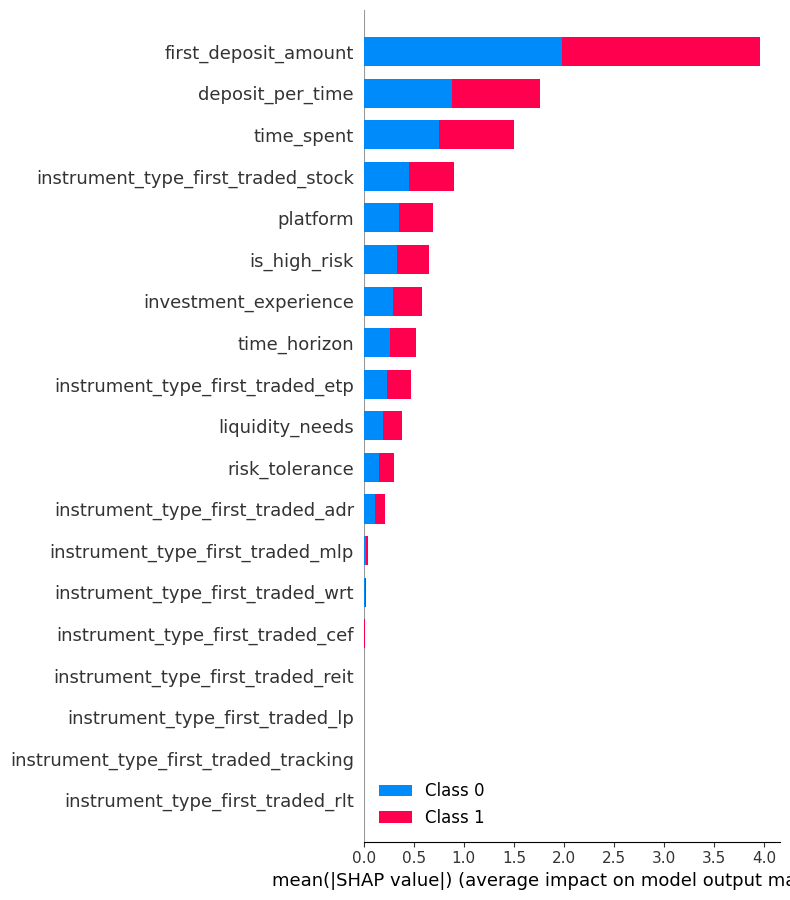

In [11]:
# SHAP for feature importance
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


### Step 6: Model Explainability with SHAP

c:\Users\cheng\Workspace\robinhood_classifer\.venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


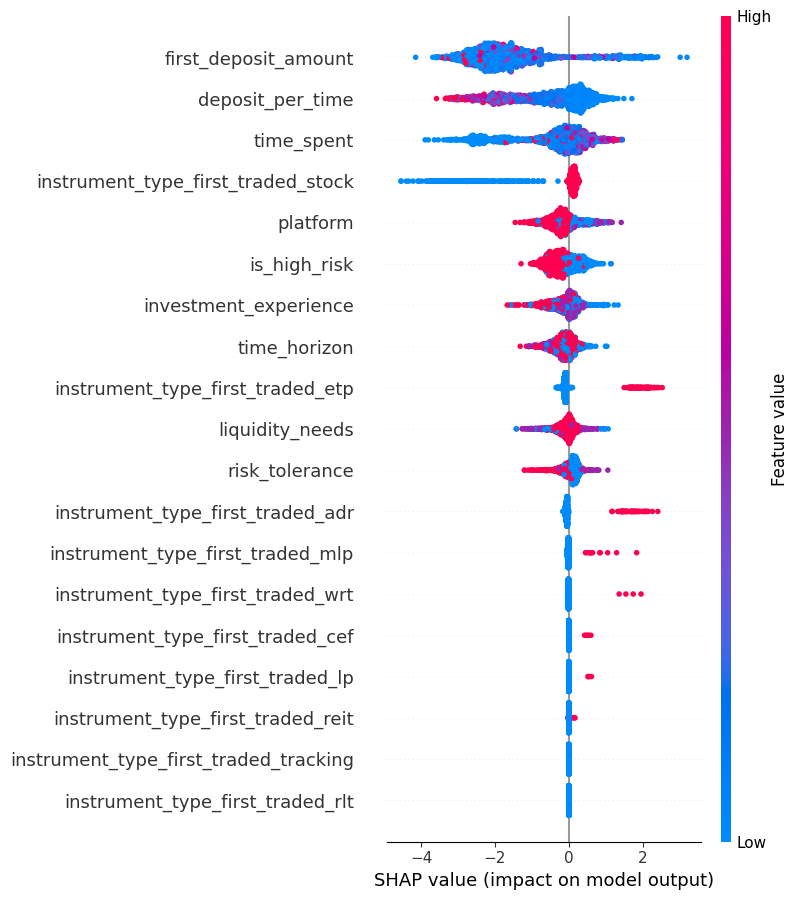

In [11]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)


## EDA

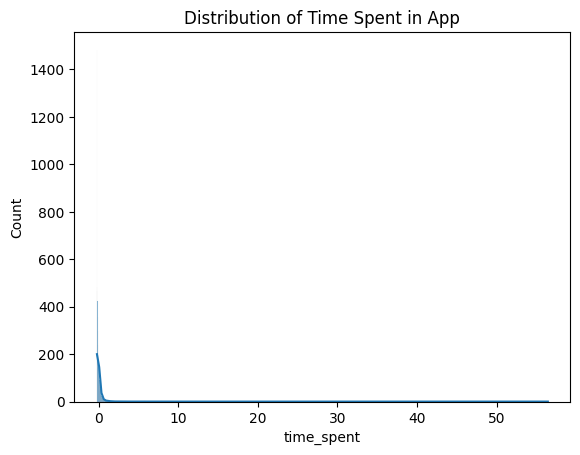

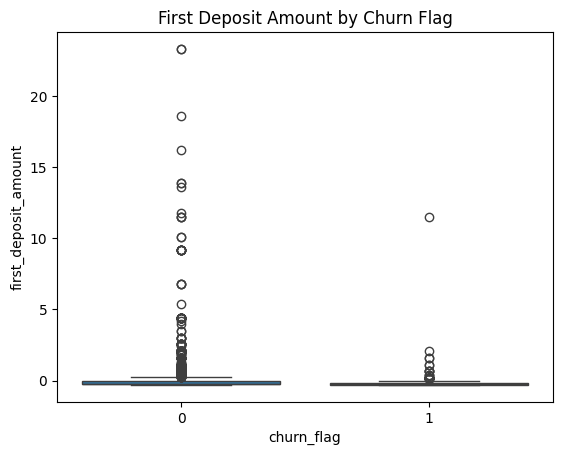

In [12]:
# Distribution of time spent in app
sns.histplot(df['time_spent'], kde=True)
plt.title('Distribution of Time Spent in App')
plt.show()

# Boxplot of first deposit amount by churn flag
sns.boxplot(x='churn_flag', y='first_deposit_amount', data=df)
plt.title('First Deposit Amount by Churn Flag')
plt.show()

# Select only the numerical columns from the DataFrame
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Create the heatmap using the correlation matrix of the numerical columns
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Countplot for churn by platform for categorical features
sns.countplot(x='platform', hue='churn_flag', data=df)
plt.title('Churn by Platform')
plt.show()
